# Plotting and exploration of SUMMA output
This document shows a workflow that creates some plots and looks at output from a hydrologic simulation model. This notebook should make repoducing the work easier.

## Goals
* Learn to work with big data and jupyter notebooks
* Set up a work flow to explore subsequent model output

In [7]:
# load all the necessary modules and packages
import netCDF4 as nc4
import pandas as pd
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta
import datetime as datetime
import glob
import scipy
import time
import csv
from scipy.io import netcdf
import os
from pathlib import Path
import os.path
from os import path


In [5]:
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Define the path with Path() because that avoids issues with how different OS' handle '/' and '\'
list_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/LISTS')						# A directory containing list control variables
output_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/EVAL_PLOTS')				# A path where the snotel SWE and snow depth
summaData_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/SUMMA_OUTPUT')			# A path that has the SUMMA output data
snotelData_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/SWE_DATA')			# A path where the snotel SWE and snow depth
statsData_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/STATS')				# A path where evaluation statistics are help
mlData_path = Path('/Users/cjh458/desktop/GHCND-metSIM-SUMMA-workflow-master/6OUTPUT_EVAL/ML_FILES')				# A path where evaluation statistics are help



stationNumber=713																	# declare number of stations to iterate through

In [6]:
# Read in lists that'll be used to open iterated files
os.chdir(list_path)											# Change directory into the folder containing lists of names

with open ("LIST_SUMMA.csv") as myfile:						# Open list containing names of Metsim-snoTEL simulations
	summafile = myfile.read().split('\n')					# Split up original .CSV into rows

with open ("LIST_SWE.csv") as myfile:						# Open list containing names of ERA5 wind data
	swefile = myfile.read().split('\n')						# Split up original .CSV into rows
    
with open ("LIST_OUTPUT.csv") as myfile:					# Open list containing names of output files
	outfile = myfile.read().split('\n')						# Split up original .CSV into rows

lledata = pd.read_csv("LLE.csv", sep=',')					# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
site_id = lledata['site_id'].values[:]						# Split up original .CSV into rows
data_length=len(summafile)										# Calculate lenght of files

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x13b19c050>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py", line 178, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


KeyboardInterrupt: 

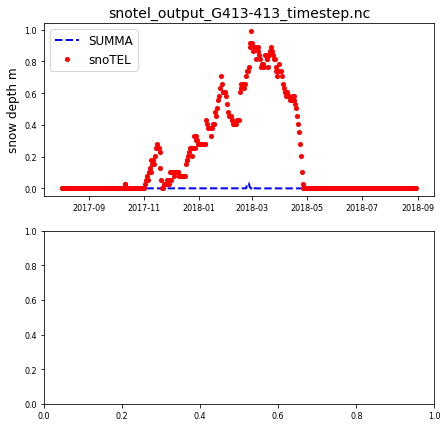

In [46]:
# Plot measured vs. modelled 
for z in range(data_length):    
    # Open the SUMMA output file
    os.chdir(summaData_path)										# Change directory into the folder that will contain SUMMA output files

    isFile = os.path.isfile(summafile[z])
    if isFile==True:   
        summaFILE = nc4.Dataset(summafile[z], 'r')						# Open a netCDF file (choose any station)
        SWE_SUMMA = summaFILE.variables['scalarSWE']					# Open snow water equivalent variable and make it == to SWE
        SSD_SUMMA = summaFILE.variables['scalarSnowDepth']				# Open snow depth variable and make it == to SDD
        SWE_length = len(SWE_SUMMA)										# Calculate length of date to make sure it's sufficient
        
        if SWE_length==9479:
            # Open the SNOTEL output file
            os.chdir(snotelData_path)								# Change directory into the folder that will contain SUMMA output files
            swedata = pd.read_csv(swefile[z], sep=',')				# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
            start=124												# declare variable = to the time corresponding to the start of time3 timeseries
            finish=519												# declare variable = to the time corresponding to the end of time3 timeseries
            SWE_SNOTEL = swedata['SWE'].values[start:finish]		# Extract data string as time1 variable					
            SSD_SNOTEL = swedata['Sdepth'].values[start:finish]/100	# Extract the snoTEL station Id number 

            # CREATE a timestamp for SUMMA data that can be plotted
            startdate = date(1990,1,1)								# Declare a start date the is used in all SUMMA simulations
            date1 = date(2017,8,1)									# Declare a variable == to the time of the start of the SUMMA simulation
            date2 = date(2018,9,1)									# Declare a variable == to the time of the end of the SUMMA simulation
            time1 = (date1-startdate).days							# Calculate the time difference in days between the start of simulation and startdate		
            time2 = (date2-startdate).days							# Calculate the time difference between the end of simulation and startdate
            int_time1 = int(time1)*24								# Multiply this difference by 24 and add the left over hours in the day to convert to total hours
            int_time2 = int(time2)*24								# Multiply this difference by 24 and add the left over hours in the day to convert to total hou
            timeSUMMA = np.arange(int_time1, int_time2)/24			# Arrange a time-series with these two dates and divide by 24 to get a fractional day 
            timeSNOTEL = np.arange(int(time1), int(time2))/24		# Arrange a time-series with these two dates and divide by 24 to get a fractional day 
            date_SUMMA=len(timeSUMMA[1:len(timeSUMMA)-24])			# Calculate the length of this time-series with an off-set to ensure conformance with original data
            date_SNOTEL=len(timeSNOTEL[1:len(timeSNOTEL)])			# Calculate the length of this time-series with an off-set to ensure conformance with original data

            base=datetime.datetime(2017,8,1,1,0)					# Declare a base time in order to create a date string that corresponds to the known time-series
            dates_SUMMA = np.array([base + datetime.timedelta(hours=(1 * i)) for i in range(date_SUMMA)]) # Create a date string time series for using as an x axis
            dates_SNOTEL = np.array([base + datetime.timedelta(days=(1 * i)) for i in range(date_SNOTEL)]) # Create a date string time series for using as an x axis 
            
            fig, ax = plt.subplots(1, 1, figsize=(7, 7))			# Initiate the creation of a figure

            plt.subplot(211)										# Create the first subplot
            ax=plt.plot(dates_SUMMA, SSD_SUMMA, 'b--', linewidth=2, markersize=8, label='SUMMA')	# Plot snow depth information from SUMMA
            ax=plt.plot(dates_SNOTEL, SSD_SNOTEL, 'r.', linewidth=2, markersize=8, label='snoTEL')	# Plot snow depth information from snoTEL
            plt.legend(loc='upper left', shadow=False, fontsize='12')	# Create a legend in the upper left
            plt.ylabel('snow depth m', fontsize=12)					# Set ylabel = to snow depth m
            plt.title(summafile[z], fontsize=14)					# Create large font header
            fig.subplots_adjust(hspace=0.2)							# Adujust head space on the top fig (doesn't do much)

            plt.subplot(212)										# Create the second subplot
            ax=plt.plot(dates_SUMMA, SWE_SUMMA, 'b--',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
            ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('snow water equivalent kg m-2', fontsize=12)	# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplots

            os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
            outPDF = 'snowFig_'										# Create a name for output figure
            outPDF += str(z+1) 										# Create a name for output figure
            outPDF += '.pdf'										# Create a name for output figure
            plt.tight_layout()										# Use command to make axis tight
            plt.savefig(outPDF, dpi=300)							# Save the figure to the new name
            plt.close()												# Close this figure

In [4]:
conda install basemap

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install -c conda-forge proj4

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - proj4


The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [6]:
conda install geos

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - geos


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.3-py37hc8dfbb8~ --> pkgs/main::conda-4.8.3-py37_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


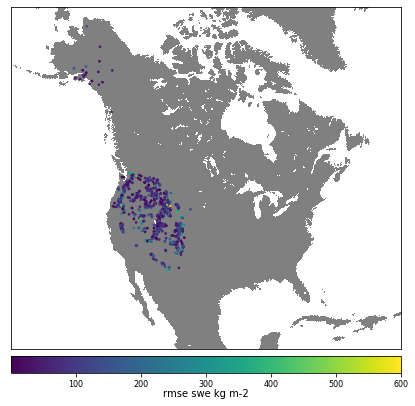

In [8]:
##################################
######## CREATE RMSE PLOT ######## 
##################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
# m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
rmse = lledata['rmse'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='viridis')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=rmse, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('rmse swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_rmse.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()												# Show plot in workspace as a check

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


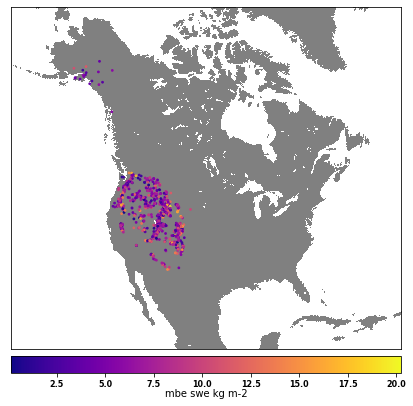

In [395]:
#################################
######## CREATE mbe PLOT ######## 
#################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
# m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
mbe = lledata['mbe'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='plasma')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=mbe, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('mbe swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_mbe.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()												# Show plot in workspace as a check

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


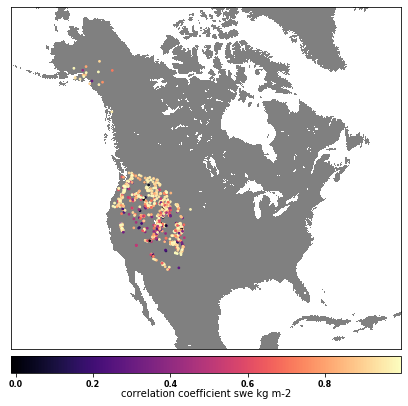

In [396]:
##################################
######## CREATE corr PLOT ######## 
##################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
# m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
r = lledata['r'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='magma')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=r, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('correlation coefficient swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_corr.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()												# Show plot in workspace as a check

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


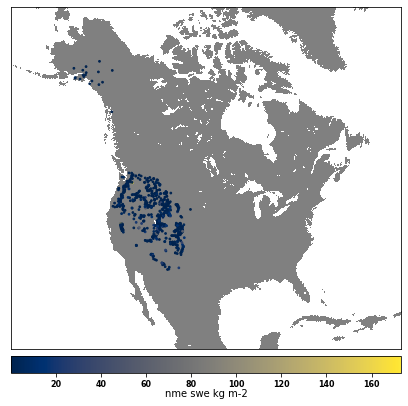

In [397]:
##################################
######## CREATE nme PLOT ######## 
##################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
# m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
nme = lledata['nme'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='cividis')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=nme, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('nme swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_nme.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()		

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


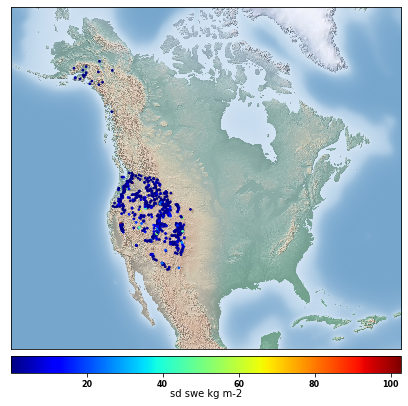

In [403]:
##################################
######## CREATE sd PLOT ######## 
##################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
sd = lledata['se'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='jet')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=sd, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('sd swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_sd.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()		

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


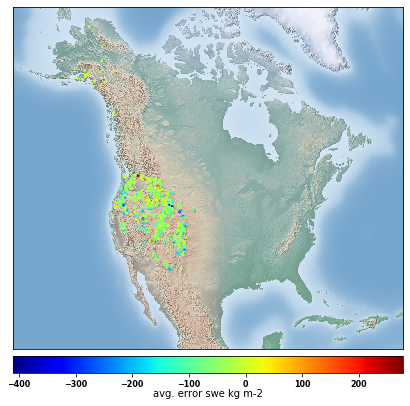

In [406]:
##################################
######## CREATE mean PLOT ######## 
##################################
# load extra modules and packages for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")	# set path to project environment
from mpl_toolkits.basemap import Basemap							# setup Lambert Conformal basemap.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) 
# Create a lambert system basemap
m = Basemap(width=8000000,height=7000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-100.)
m.drawlsmask(land_color='grey')
m.shadedrelief()
# m.drawcoastlines() 													# draw coastlines.
os.chdir(statsData_path)									# Move into directory with the statistics file
# import statistical data into the workspace
lledata = pd.read_csv("evaluationStatistics.csv", sep=',')	# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
mean = lledata['mean'].values[:]							# Split up original .CSV into rows
lat = lledata['lat'].values[:]							# Split up original .CSV into rows
lon = lledata['lon'].values[:]							# Split up original .CSV into rows
# set glotal attributes for colormap and font
plt.rc('image', cmap='jet')							# Set RC attribute for colormap
plt.rc('font',size=8)									# Set rc attribute for font size
# flip lat and lon to work with graphing conventions for base map
xpt, ypt = m(lon, lat)									# Calcualte x and ys from lats and lons
m.scatter(xpt, ypt, c=mean, s=3)						# Create a scatter plot with basemap conventions
m.colorbar(location='bottom')							# Include a colorbar
plt.xlabel('avg. error swe kg m-2', labelpad=40, fontsize=10)			# Add xlabel to plot
# CD and save figure to a pdf file
os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
plt.savefig('snotel_mean.pdf', dpi=300, bbox_inches='tight')	# Save fig as a PDF
plt.show()		

In [906]:
# -*- coding: utf-8 -*-
# Layer plotting for SUMMA output

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator


test_length=10

for z in range(test_length):    
    # Open the SUMMA output file
    os.chdir(summaData_path)													# Change directory into the folder that will contain SUMMA output files

    isFile = os.path.isfile(summafile[z])
    if isFile==True:   
        summaFILE = nc4.Dataset(summafile[z], 'r')								# Open a netCDF file (choose any station)
        
        SWE_SUMMA = summaFILE.variables['scalarSWE']							# Open snow water equivalent variable and make it == to SWE
        SSD_SUMMA = summaFILE.variables['scalarSnowDepth']						# Open snow depth variable and make it == to SDD         
        STSW_SUMMA = summaFILE.variables['scalarTotalSoilWat']					# Open total soil water variable variable
        STR_SUMMA = summaFILE.variables['scalarTotalRunoff_mean']				# Open variable
        LH_SUMMA = summaFILE.variables['scalarLatHeatTotal_mean']				# Open variable
        ET_SUMMA = summaFILE.variables['scalarTotalET_mean']					# Open variable
        IM_SUMMA = summaFILE.variables['scalarInfiltration_mean']				# Open variable
        SDM_SUMMA = summaFILE.variables['scalarSoilDrainage_mean']				# Open variable      
        AS_SUMMA = summaFILE.variables['scalarAquiferStorage']					# Open variable 
        BF_SUMMA = summaFILE.variables['scalarAquiferBaseflow_mean']			# Open variable
        SS_SUMMA = summaFILE.variables['scalarSnowSublimation_mean']			# Open variable
        SBF_SUMMA = summaFILE.variables['scalarSoilBaseflow_mean']				# Open variable
        RPM_SUMMA = summaFILE.variables['scalarRainPlusMelt_mean']				# Open variable
        TEMP_SUMMA = summaFILE.variables['mLayerTemp']							# Open variable
        mICE_SUMMA = summaFILE.variables['mLayerVolFracIce']					# Open variable
        mWAT_SUMMA = summaFILE.variables['mLayerVolFracWat']					# Open variable
        
        SWE_length = len(SWE_SUMMA)												# Calculate length of date to make sure it's sufficient
        
        if SWE_length==9479:
            # Open the SNOTEL output file
            os.chdir(snotelData_path)								# Change directory into the folder that will contain SUMMA output files
            swedata = pd.read_csv(swefile[z], sep=',')				# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
            start=124												# declare variable = to the time corresponding to the start of time3 timeseries
            finish=519												# declare variable = to the time corresponding to the end of time3 timeseries
            SWE_SNOTEL = swedata['SWE'].values[start:finish]		# Extract data string as time1 variable					
            SSD_SNOTEL = swedata['Sdepth'].values[start:finish]/100	# Extract the snoTEL station Id number 
            
            # CREATE a timestamp for SUMMA data that can be plotted
            startdate = date(1990,1,1)								# Declare a start date the is used in all SUMMA simulations
            date1 = date(2017,8,1)									# Declare a variable == to the time of the start of the SUMMA simulation
            date2 = date(2018,9,1)									# Declare a variable == to the time of the end of the SUMMA simulation
            time1 = (date1-startdate).days							# Calculate the time difference in days between the start of simulation and startdate		
            time2 = (date2-startdate).days							# Calculate the time difference between the end of simulation and startdate
            int_time1 = int(time1)*24								# Multiply this difference by 24 and add the left over hours in the day to convert to total hours
            int_time2 = int(time2)*24								# Multiply this difference by 24 and add the left over hours in the day to convert to total hou
            timeSUMMA = np.arange(int_time1, int_time2)/24			# Arrange a time-series with these two dates and divide by 24 to get a fractional day 
            timeSNOTEL = np.arange(int(time1), int(time2))/24		# Arrange a time-series with these two dates and divide by 24 to get a fractional day 
            date_SUMMA=len(timeSUMMA[1:len(timeSUMMA)-24])			# Calculate the length of this time-series with an off-set to ensure conformance with original data
            date_SNOTEL=len(timeSNOTEL[1:len(timeSNOTEL)])			# Calculate the length of this time-series with an off-set to ensure conformance with original data

            base=datetime.datetime(2017,8,1,1,0)					# Declare a base time in order to create a date string that corresponds to the known time-series
            dates_SUMMA = np.array([base + datetime.timedelta(hours=(1 * i)) for i in range(date_SUMMA)]) # Create a date string time series for using as an x axis
            dates_SNOTEL = np.array([base + datetime.timedelta(days=(1 * i)) for i in range(date_SNOTEL)]) # Create a date string time series for using as an x axis 
            
            plt.rc('image', cmap='jet')								# Set RC attribute for colormap
            plt.rc('font',size=8)									# Set rc attribute for font size
            
            ####### PLOT FIG 1 #######
            
            fig, ax = plt.subplots(1, 1, figsize=(12, 16))			# Initiate the creation of a figure

            plt.subplot(311)										# Create the first subplot
            ax=plt.plot(dates_SUMMA, LH_SUMMA, 'k--', linewidth=1, markersize=8, label='SUMMA')	# Plot snow depth information from SUMMA
#             ax=plt.plot(dates_SNOTEL, SSD_SNOTEL, 'r.', linewidth=2, markersize=8, label='snoTEL')	# Plot snow depth information from snoTEL
#             plt.legend(loc='upper left', shadow=False, fontsize='12')	# Create a legend in the upper left
            plt.ylabel('Latent heat canopy-atmosphere W m-2', fontsize=12)					# Set ylabel = to snow depth m
            plt.title(summafile[z], fontsize=14)					# Create large font header
            fig.subplots_adjust(hspace=0.2)							# Adujust head space on the top fig (doesn't do much)

            plt.subplot(312)										# Create the second subplot
            ax=plt.plot(dates_SUMMA, ET_SUMMA, 'k--',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('Evapotranspiration kg m-2 s-1', fontsize=12)	# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplots

            plt.subplot(313)										# Create the second subplot
            ax=plt.plot(dates_SUMMA[3:SWE_len], STR_SUMMA[3:SWE_len], 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('total runoff m s-1', fontsize=12)	# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplot
            
            os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
            outPDF = 'laugh1_'										# Create a name for output figure
            outPDF += str(z+1) 										# Create a name for output figure
            outPDF += '.pdf'										# Create a name for output figure
            plt.tight_layout()										# Use command to make axis tight
            plt.savefig(outPDF, dpi=300)							# Save the figure to the new name
#             plt.show()		
            plt.close()												# Close this figure
            
            
            ####### PLOT FIG 2 #######
            
            fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))			# Initiate the creation of a figure

            plt.subplot(311)										# Create the first subplot
            ax=plt.plot(dates_SUMMA, IM_SUMMA, 'k-', linewidth=1, markersize=8, label='SUMMA')	# Plot snow depth information from SUMMA
#             ax=plt.plot(dates_SNOTEL, SSD_SNOTEL, 'r.', linewidth=2, markersize=8, label='snoTEL')	# Plot snow depth information from snoTEL
#             plt.legend(loc='upper left', shadow=False, fontsize='12')	# Create a legend in the upper left
            plt.ylabel('soil infiltration m s-1', fontsize=12)		# Set ylabel = to snow depth m
            plt.title(summafile[z], fontsize=14)					# Create large font header
            fig.subplots_adjust(hspace=0.2)							# Adujust head space on the top fig (doesn't do much)

            plt.subplot(312)										# Create the second subplot
            ax=plt.plot(dates_SUMMA[3:SWE_len], SDM_SUMMA[3:SWE_len], 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('soil drainage m s-1', fontsize=12)			# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplots

            plt.subplot(313)										# Create the second subplot
            ax=plt.plot(dates_SUMMA, STSW_SUMMA, 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('total soil water kg m-2', fontsize=12)	# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplots

            
            os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
            outPDF = 'laugh2_'										# Create a name for output figure
            outPDF += str(z+1) 										# Create a name for output figure
            outPDF += '.pdf'										# Create a name for output figure
            plt.tight_layout()										# Use command to make axis tight
            plt.savefig(outPDF, dpi=300)							# Save the figure to the new name
#             plt.show()		
            plt.close()												# Close this figure
            
            
            ####### PLOT FIG 3 #######
                
            fig, ax2 = plt.subplots(1, 1, figsize=(12, 12))			# Initiate the creation of a figure

            plt.subplot(311)										# Create the second subplot
            ax2=plt.plot(dates_SUMMA[3:SWE_len], AS_SUMMA[3:SWE_len], 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('depth between aquifer water and soil m', fontsize=12)			# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplot
            
            plt.subplot(312)										# Create the second subplot
            ax2=plt.plot(dates_SUMMA[3:SWE_len], BF_SUMMA[3:SWE_len], 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('base flow from aquifer m s-1', fontsize=12)			# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplot
            
            plt.subplot(313)										# Create the second subplot
            ax2=plt.plot(dates_SUMMA, SBF_SUMMA, 'k-',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
#             ax=plt.plot(dates_SNOTEL, SWE_SNOTEL, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
            plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
            plt.ylabel('baseflow from the soil m s-1', fontsize=12)			# Set ylabel = to snow water equivalent units
            fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplot
            
            os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
            outPDF = 'laugh3_'										# Create a name for output figure
            outPDF += str(z+1) 										# Create a name for output figure
            outPDF += '.pdf'										# Create a name for output figure
            plt.tight_layout()										# Use command to make axis tight
            plt.savefig(outPDF, dpi=300)							# Save the figure to the new name
#             plt.show()		
            plt.close()												# Close this figure
            
            
            ####### PLOT FIG 4 #######
            
#             fig, ax = plt.subplots(2, 1, figsize=(12, 4))			# Initiate the creation of a figure

#             fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 4))
            
            mld = [0.0125,0.0125,0.025,0.05,0.1,0.1,0.1,0.1]			# Declare a time-series that gives the depth of each soil layer
            ilh=[0,0.0125,0.025,0.05,0.1,0.2,0.3,0.4,0.5]				# Declare a time-series that gives the depth at the bottom of each layer 
            base=0														# Declare an arbritary counting variable that gives the depth of the midpoint of each soil layer at a fixed width
            xnew=[0,0,0,0,0,0,0,0]										# Declare an empty xnew parameter that will be initiallized with the equal widths
            xx=[0,0,0,0,0,0,0,0]										# Declare an xx soil depth parameter that gives the middle of the existing uneven layers
            for i in range (len(mld)):									# Iterate through layer
                xx[i]=(mld[i]/2)+base									# Caluclate xx using the existing layer depths and thicknesses
                base=base+mld[i]										# Calculate a new base at each later iteration
                xnew[i]=0.0+(i+1)*0.06									# Calculate the xnew for each layer
                
            TEMP1_SUMMA=np.squeeze(TEMP_SUMMA)							# remove redundant dimension from m layer temperature variable
            TEMP2_SUMMA=np.rot90(TEMP1_SUMMA,1)							# rotate the dimensions so they will plot correctly
            mICE1_SUMMA=np.squeeze(mICE_SUMMA)							# remove redundant dimension from m layer ice variable
            mICE2_SUMMA=np.rot90(mICE1_SUMMA,1)							# rotate the dimensions so they will plot correctly
            mWAT1_SUMMA=np.squeeze(mWAT_SUMMA)							# remove redundant dimension from m layer water variable
            mWAT2_SUMMA=np.rot90(mWAT1_SUMMA,1)							# rotate the dimensions so they will plot correctly
            
            for i in range(len(TEMP2_SUMMA)):
                y=interp1d(xx,TEMP2_SUMMA[:,i],fill_value="extrapolate")			# Create a 1D interpolation for the temperature variable
                TEMP2_SUMMA[:,i]=y(xnew)											# Resample this variable at the xnew x values
                y=interp1d(xx,mICE2_SUMMA[:,i],fill_value="extrapolate")			# Create a 1D interpolation for the mICE variable
                mICE2_SUMMA[:,i]=y(xnew)											# Resample this variable at the xnew x values
                y=interp1d(xx,mWAT2_SUMMA[:,i],fill_value="extrapolate")			# Create a 1D interpolation for the mWAT variable
                mWAT2_SUMMA[:,i]=y(xnew)											# Resample this variable at the xnew x values
           
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(12, 12))
            
            x_lims = mdates.date2num(dates_SUMMA)												# Declare x_lims variable == to the mdates.date2num function
            im1=ax1.imshow(TEMP2_SUMMA[:,:]-273.15, extent = [x_lims[0], x_lims[len(x_lims)-1], xnew[len(xx)-1], xnew[0]], aspect='auto', origin='lower')
            ax1.xaxis_date()																	# We tell Matplotlib that the x-axis is filled with datetime data, 
            date_format = mdates.DateFormatter('%y/%m')											# Declare a date format that shows year and month
            ax1.xaxis.set_major_formatter(date_format)											# Implement this date format
            divider1 = make_axes_locatable(ax1)
            cax1 = divider1.append_axes("right", size="4%", pad=0.1)
            cbar1 = plt.colorbar(im1, cax=cax1)													# insert a colorbar
            cbar1.set_label('soil temperature °C',size=8, labelpad=10, rotation=270)
            ax1.set_title(summafile[z], fontsize=10)											# Create large font header
            fig.subplots_adjust(hspace=0.2)														# Adjust head space on the top fig (doesn't do much)
            fig.autofmt_xdate()																	# Add an autoformat statement that turns text on a diagonal

            im2=ax2.imshow(mICE2_SUMMA[:,:], extent = [x_lims[0], x_lims[len(x_lims)-1], xnew[len(xx)-1], xnew[0]], aspect='auto', origin='lower')
            ax2.xaxis_date()																		# We tell Matplotlib that the x-axis is filled with datetime data, 
            date_format = mdates.DateFormatter('%y/%m')											# Declare a date format that shows year and month
            ax2.xaxis.set_major_formatter(date_format)											# Implement this date format
            divider2 = make_axes_locatable(ax2)
            cax2 = divider2.append_axes("right", size="4%", pad=0.1)
            cbar2 = plt.colorbar(im2, cax=cax2)																	# insert a colorbar
            cbar2.set_label('soil ice content %/%',size=8, labelpad=10, rotation=270)
            ax2.set_ylabel('soil depth m', fontsize=8)												# Set ylabel = to snow depth m
            fig.subplots_adjust(hspace=0.2)														# Adjust head space on the top fig (doesn't do much)
            fig.autofmt_xdate()																	# Add an autoformat statement that turns text on a diagonal
       
            im3=ax3.imshow(mWAT2_SUMMA[:,:], extent = [x_lims[0], x_lims[len(x_lims)-1], xnew[len(xx)-1], xnew[0]], aspect='auto', origin='lower')
            ax3.xaxis_date()																		# We tell Matplotlib that the x-axis is filled with datetime data, 
            date_format = mdates.DateFormatter('%y/%m')											# Declare a date format that shows year and month
            ax3.xaxis.set_major_formatter(date_format)											# Implement this date format
            divider3 = make_axes_locatable(ax3)
            cax3 = divider3.append_axes("right", size="4%", pad=0.1)
            cbar3 = plt.colorbar(im3, cax=cax3)																	# insert a colorbar
            cbar3.set_label('soil water content %/%',size=8, labelpad=10, rotation=270)
#             ax3.set_xlabel('time (date)', fontsize=8)												# Set ylabel = to snow depth m
            ax3.set_ylabel('soil depth m', fontsize=8)												# Set ylabel = to snow depth m        
            fig.subplots_adjust(hspace=0.2)														# Adjust head space on the top fig (doesn't do much)
            fig.autofmt_xdate()																	# Add an autoformat statement that turns text on a diagonal

            
            im4=ax4.imshow(mWAT2_SUMMA[:,:]+mICE2_SUMMA[:,:], extent = [x_lims[0], x_lims[len(x_lims)-1], xnew[len(xx)-1], xnew[0]], aspect='auto', origin='lower')
            ax4.xaxis_date()																		# We tell Matplotlib that the x-axis is filled with datetime data, 
            date_format = mdates.DateFormatter('%y/%m')											# Declare a date format that shows year and month
            ax4.xaxis.set_major_formatter(date_format)											# Implement this date format
            divider4 = make_axes_locatable(ax4)
            cax4 = divider4.append_axes("right", size="4%", pad=0.1)
            cbar4 = plt.colorbar(im4, cax=cax4)																	# insert a colorbar
            cbar4.set_label('soil water+ice content %/%',size=8, labelpad=10, rotation=270)
            ax4.set_xlabel('time (date)', fontsize=8)												# Set ylabel = to snow depth m
            fig.subplots_adjust(hspace=0.2)														# Adjust head space on the top fig (doesn't do much)
            fig.autofmt_xdate()																	# Add an autoformat statement that turns text on a diagonal
 
            os.chdir(output_path)									# Change directory into the folder that will contain SUMMA output files
            outPDF = 'laugh4_'										# Create a name for output figure
            outPDF += str(z+1) 										# Create a name for output figure
            outPDF += '.pdf'										# Create a name for output figure
            plt.tight_layout()										# Use command to make axis tight
            plt.savefig(outPDF, dpi=300)							# Save the figure to the new name
#             plt.show()		
            plt.close()												# Close this figure
            

In [729]:
conda install pytorch torchvision -c pytorch

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


0 18349360.0
1000 472652.40625
2000 88208.5546875
3000 111100.84375
4000 65771.84375
5000 67032.3203125
6000 56584.34375
7000 46762.09765625
8000 73094.5625
9000 46292.765625


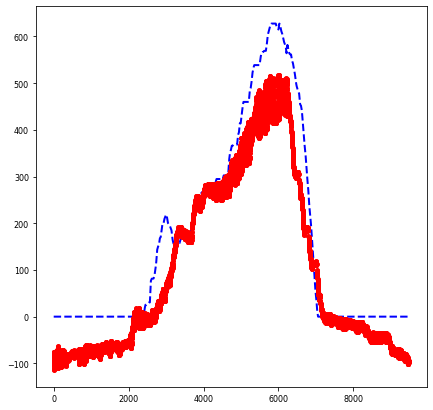

In [45]:
# -*- coding: utf-8 -*-
# load additional modules and packages
import torch
import numpy as np

test_length=1

for z in range(test_length):    
    # Open the SUMMA output file
    os.chdir(summaData_path)												# Change directory into the folder that will contain SUMMA output files

    isFile = os.path.isfile(summafile[z])
    if isFile==True:   
        summaFILE = nc4.Dataset(summafile[z], 'r')							# Open a netCDF file (choose any station)
        
        SWE_SUMMA = summaFILE.variables['scalarSWE']						# Open snow water equivalent variable and make it == to SWE
#         SSD_SUMMA = summaFILE.variables['scalarSnowDepth']				# Open snow depth variable and make it == to SDD
        SWE_length = len(SWE_SUMMA)											# Calculate length of date to make sure it's sufficient
   
        if SWE_length==9479:
            # Open the ML training file
            os.chdir(mlData_path)											# Change directory into the folder that will contain SUMMA output files
            mlFILE = nc4.Dataset('snotel_forcing_ML.nc', 'r')				# Open a netCDF file (choose any station)
            start=2929														# declare variable = to the time corresponding to the start of SUMMA output timeseries
            finish=12408													# declare variable = to the time corresponding to the end of SUMMA output timeseries
           
            time_ML = mlFILE.variables['time']								# Open snow water equivalent variable and make it == to SWE
            
            SWE_ML = mlFILE.variables['swe']							# Open snow water equivalent variable and make it == to SWE
            PREC_ML = mlFILE.variables['pptrate']						# Open cumulative precipitation variable and make it == to pptrate
            LWR_ML = mlFILE.variables['LWRadAtm']						# Open Long wave radiation variable and make it == LWRadAtm
            SWR_ML = mlFILE.variables['SWRadAtm']						# Open Short wave ratiation variable and make it == SWRadAtm
            PRES_ML = mlFILE.variables['airpres']						# Open air pressure variable and make it == airpres
            TEMP_ML = mlFILE.variables['airtemp']						# Open air temperature variable and make it == airtemp                   
            SH_ML = mlFILE.variables['spechum']							# Open specific humidity variable and make it == spechum
            WDSP_ML = mlFILE.variables['windspd']						# Open windspd variable and make it == windspd
           
            time_ML = time_ML[start:finish]					# Cut to the data-time for summa snow water equivalent variable and make it == to SWE
            SWE_ML = SWE_ML[start:finish,:]						# Cut to the data-time for summa snow water equivalent variable and make it == to SWE
            PREC_ML = PREC_ML[start:finish,:]					# Cut to the data-time for summa cumulative precipitation variable and make it == to pptrate
            LWR_ML = LWR_ML[start:finish,:]						# Cut to the data-time for summa Long wave radiation variable and make it == LWRadAtm
            SWR_ML = SWR_ML[start:finish,:]						# Cut to the data-time for summa Short wave ratiation variable and make it == SWRadAtm
            PRES_ML = PRES_ML[start:finish,:]					# Cut to the data-time for summa air pressure variable and make it == airpres
            TEMP_ML = TEMP_ML[start:finish,:]					# Cut to the data-time for summa air temperature variable and make it == airtemp                   
            SH_ML = SH_ML[start:finish,:]						# Cut to the data-time for summa specific humidity variable and make it == spechum
            WDSP_ML = WDSP_ML[start:finish,:]					# Cut to the data-time for summa windspd variable and make it == windspd
       
            SWE_len=len(SWE_ML)
#             os.chdir(snotelData_path)										# Change directory into the folder that will contain SUMMA output files
#             swedata = pd.read_csv(swefile[4], sep=',')					# Use pandas read_csv function to declare a variable = to a .csv file with a ; delimiter 
#             start=124														# declare variable = to the time corresponding to the start of time3 timeseries
#             finish=519													# declare variable = to the time corresponding to the end of time3 timeseries
#             SWE_SNOTEL = (swedata['SWE'].values[start:finish]			# Extract data string as time1 variable					
#             SSD_SNOTEL = swedata['Sdepth'].values[start:finish]			# Extract the snoTEL station Id number 
#             Tmin_SNOTEL = swedata['Tmin'].values[start:finish]			# Extract the snoTEL station Id number 
#             Tmax_SNOTEL = swedata['Tmax'].values[start:finish]			# Extract the snoTEL station Id number 
#             Prec_SNOTEL = swedata['Prec'].values[start:finish]			# Extract the snoTEL station Id number 
            
            # N is batch size; D_in is input dimension;
            # H is hidden dimension; D_out is output dimension.
            SWE_len1=(SWE_len)
            SWE_len=(SWE_len//10)
            
            N, D_in, H, D_out = SWE_len, 7, 100, 1
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

            # Create random Tensors to hold inputs and outputs
            R = np.random.randint(0,SWE_len1,SWE_len)

            xx = np.zeros((N,D_in))
            yy = np.zeros((N,D_out))
            
            xx1 = np.zeros((SWE_len1,D_in))
            yy1 = np.zeros((SWE_len1,D_out))

            for j in range(N):
                xx[j,0] = np.double(PREC_ML[R[j],z])
                xx[j,1] = np.double(LWR_ML[R[j],z])
                xx[j,2] = np.double(SWR_ML[R[j],z])
                xx[j,3] = np.double(PRES_ML[R[j],z])
                xx[j,4] = np.double(TEMP_ML[R[j],z])
                xx[j,5] = np.double(SH_ML[R[j],z])
                xx[j,6] = np.double(WDSP_ML[R[j],z])
                yy[j,0] = np.double(SWE_ML[R[j],z])
                
            for j in range(SWE_len1):
                xx1[j,0] = np.double(PREC_ML[j,z])
                xx1[j,1] = np.double(LWR_ML[j,z])
                xx1[j,2] = np.double(SWR_ML[j,z])
                xx1[j,3] = np.double(PRES_ML[j,z])
                xx1[j,4] = np.double(TEMP_ML[j,z])
                xx1[j,5] = np.double(SH_ML[j,z])
                xx1[j,6] = np.double(WDSP_ML[j,z])
                yy1[j,0] = np.double(SWE_ML[j,z])
                
            x=torch.from_numpy(xx).float() 
            y=torch.from_numpy(yy).double()
            x1=torch.from_numpy(xx1).float() 
            y1=torch.from_numpy(yy1).double()
            
            train_data = torch.utils.data.TensorDataset(x, y)
            train_loader = torch.utils.data.DataLoader(train_data)

            x = x.type(torch.Tensor)
            y = y.type(torch.Tensor)
            x1 = x1.type(torch.Tensor)
            y1 = y1.type(torch.Tensor)
            
            # Use the nn package to define our model and loss function.
            model = torch.nn.Sequential(
                torch.nn.Linear(D_in, H),
                torch.nn.ReLU(),
                torch.nn.Linear(H, D_out),
            )
            loss_fn = torch.nn.MSELoss(reduction='sum')
#             loss_fn = torch.nn.L1Loss(reduction='sum')

            # Use the optim package to define an Optimizer that will update the weights of
            # the model for us. Here we will use Adam; the optim package contains many other
            # optimization algoriths. The first argument to the Adam constructor tells the
            # optimizer which Tensors it should update.
            learning_rate = 1e-2
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            for t in range(10000):
                # Forward pass: compute predicted y by passing x to the model.
                y_pred = model(x)

                # Compute and print loss.
                loss = loss_fn(y_pred, y)
                if t % 1000 == 0:
                    print(t, loss.item())

                # Before the backward pass, use the optimizer object to zero all of the
                # gradients for the variables it will update (which are the learnable
                # weights of the model). This is because by default, gradients are
                # accumulated in buffers( i.e, not overwritten) whenever .backward()
                # is called. Checkout docs of torch.autograd.backward for more details.
                optimizer.zero_grad()

                # Backward pass: compute gradient of the loss with respect to model
                # parameters
                loss.backward()

                # Calling the step function on an Optimizer makes an update to its
                # parameters
                optimizer.step()

            yy_pred = model(x1)
            yy_pred = yy_pred.detach().numpy()
            y_pred = y_pred.detach().numpy()
            zero=0
            xy=np.arange(int(zero),int(len(y_pred)))
            xy1=np.arange(int(zero),int(len(yy_pred)))
            ML1=np.copy(yy_pred)
            os.chdir('OUTPUT')
            # EXPORT PREDICTION TO FILE??
            ncid = nc4.Dataset(outfile[z], "w", format="NETCDF4")			# Open a new file for writing ML_data
            dimid_Test = ncid.createDimension('time', SWE_len1) # Declare time dimension that is the same length of the data file
            dimid_Train = ncid.createDimension('train', SWE_len) # Declare time dimension that is the same length of the data file
            dimid_hru = ncid.createDimension('hru', 1)					# Declare hydrological response unit dimension of 1
  
            # Create time variable
            time_varid = ncid.createVariable('time','d',('time'))
            # Declare variable attributes
            time_varid.units          = 'days since 1990-01-01 00:00:00'    # Declare time formatting
            time_varid.long_name      = 'Observation time'                  # Add time attribute
            time_varid.calendar       = 'standard'                          # Add another time attribute
            # Write SUMMA model SWE variable
            time_varid[0:SWE_len1] = time_ML[0:SWE_len1]			# Write data to SNOTEL
            
            # Create time variable
            train_varid = ncid.createVariable('train','d',('train'))
            # Declare variable attributes
            train_varid.units          = 'days since 1990-01-01 00:00:00'    # Declare time formatting
            train_varid.long_name      = 'Observation time'                  # Add time attribute
            train_varid.calendar       = 'standard'                          # Add another time attribute
            # Write SUMMA model SWE variable
            train_varid[0:SWE_len] = time_ML[R[0:SWE_len]]			# Write data to SNOTEL
            
            # Create time variable
            train_ML_varid = ncid.createVariable('train_ML','d',('train'))
            # Declare variable attributes
            train_ML_varid.units          = 'kg m-2'
            train_ML_varid.long_name      = 'SUMMA model SWE'
            train_ML_varid.FillValue      = '-999.f'
            # Write SUMMA model SWE variable
            train_ML_varid[0:SWE_len] = y_pred[0:SWE_len]			# Write data to SNOTEL 
            
            # Create time variable
            train_SWE_varid = ncid.createVariable('train_SWE','d',('train'))
            # Declare variable attributes
            train_SWE_varid.units          = 'kg m-2'
            train_SWE_varid.long_name      = 'SUMMA model SWE'
            train_SWE_varid.FillValue      = '-999.f'
            # Write SUMMA model SWE variable
            train_SWE_varid[0:SWE_len] = y[0:SWE_len]			# Write data to SNOTEL 
            
            # Create SUMMA SWE variable
            SUMMA_varid = ncid.createVariable('SUMMA','d',('time'))
            # Declare variable attributes
            SUMMA_varid.units          = 'kg m-2'
            SUMMA_varid.long_name      = 'SUMMA model SWE'
            SUMMA_varid.FillValue      = '-999.f'
            # Write ML data to the variable
            SUMMA_varid[0:SWE_len1] = SWE_SUMMA[0:SWE_len1]			# Write data to SUMMA
            
            # Write SNOTEL SWE variable
            SNOTEL_varid = ncid.createVariable('SNOTEL','d',('time'))
            # Declare variable attributes
            SNOTEL_varid.units          = 'kg m-2'
            SNOTEL_varid.long_name      = 'SNOTEL measured SWE'
            SNOTEL_varid.FillValue      = '-999.f'
            # Write ML data to the variable
            SNOTEL_varid[0:SWE_len1] = SWE_ML[0:SWE_len1,z]			# Write data to SNOTEL
            
            # Write ML SWE variable
            ML_varid = ncid.createVariable('ML','d',('time'))
            # Declare variable attributes
            ML_varid.units          = 'kg m-2'
            ML_varid.long_name      = 'ML nn model of SWE'
            ML_varid.FillValue      = '-999.f'
            # Write ML data to the variable
            ML_varid[0:SWE_len1] = ML1[0:SWE_len1]			# Write data to ML
                 
            ncid.close()									# close MetSim Datafile 

ax=plt.plot(xy1, y1, 'b--',linewidth=2, markersize=8)	# Plot the SUMMA swe dat
ax1=plt.plot(xy1, yy_pred, 'r.',linewidth=2, markersize=8)	# Plot the Swe data from SNOTEL
# plt.xlabel('time', fontsize=12)							# Set xlabel = to time only on the bottom figure
# plt.ylabel('snow water equivalent kg m-2', fontsize=12)	# Set ylabel = to snow water equivalent units
# fig.subplots_adjust(hspace=0.2)							# make a little extra space between the subplots
plt.show()	
